## DrawFigs-oracle-models-evolution

https://docs.google.com/presentation/d/1kT_ZMYjwt9WWNN3Pk0MH5J22lVjGpFm9P2FEwtUxlsU/edit#slide=id.p
    

In [24]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
import copy
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from pathlib import Path
import configparser

from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.dataset.util import to_pandas

from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8
#_featureCnt = 9

# added new features
COL_LEADER_PITCNT = 9
COL_TOTAL_PITCNT = 10
COL_SHIFT_TRACKSTATUS = 11
COL_SHIFT_LAPSTATUS = 12
COL_SHIFT_LEADER_PITCNT = 13
COL_SHIFT_TOTAL_PITCNT = 14

COL_LASTFEATURE = 14
# dynamically extended space in simulation
COL_TRACKSTATUS_SAVE = COL_LASTFEATURE+1
COL_LAPSTATUS_SAVE = COL_LASTFEATURE+2
COL_CAUTION_LAPS_INSTINT_SAVE = COL_LASTFEATURE+3
COL_LAPS_INSTINT_SAVE= COL_LASTFEATURE+4

COL_ENDPOS = COL_LASTFEATURE+5


FEATURE_STATUS = 2
FEATURE_PITAGE = 4
FEATURE_LEADER_PITCNT = 8
FEATURE_TOTAL_PITCNT = 16
FEATURE_SHIFT_TRACKSTATUS = 32
FEATURE_SHIFT_LAPSTATUS = 64
FEATURE_SHIFT_LEADER_PITCNT = 128
FEATURE_SHIFT_TOTAL_PITCNT  = 256

_feature2str= {
    FEATURE_STATUS : ("FEATURE_STATUS",'S'),
    FEATURE_PITAGE : ("FEATURE_PITAGE",'A'),
    FEATURE_LEADER_PITCNT : ("FEATURE_LEADER_PITCNT",'L'),
    FEATURE_TOTAL_PITCNT : ("FEATURE_TOTAL_PITCNT",'T'),
    FEATURE_SHIFT_TRACKSTATUS : ("FEATURE_SHIFT_TRACKSTATUS",'Y'),
    FEATURE_SHIFT_LAPSTATUS : ("FEATURE_SHIFT_LAPSTATUS",'P'),
    FEATURE_SHIFT_LEADER_PITCNT : ("FEATURE_SHIFT_LEADER_PITCNT",'L'),
    FEATURE_SHIFT_TOTAL_PITCNT  : ("FEATURE_SHIFT_TOTAL_PITCNT",'T')
    }


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

#_feature_mode = FEATURE_STATUS
def decode_feature_mode(feature_mode):
    
    retstr = []
    short_ret = []
    for feature in _feature2str.keys():
        if test_flag(feature_mode, feature):
            retstr.append(_feature2str[feature][0])
            short_ret.append(_feature2str[feature][1])
        else:
            short_ret.append('0')

    print(' '.join(retstr))
    
    return ''.join(short_ret)

In [25]:
def ploth(ts_entry, forecast_entry, pits,caution, pitstop,outputfile,
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet'],
                   ylabel = 'RANK'):

    #plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        ax = plt.subplot(figcnt, 1, idx+1)
        #ax = plt.subplot(1, figcnt, idx+1)
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        #plot_length = int(forecast_entry[idx].samples.shape[1] *1.2) 
        ts_entry[idx].iloc[:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 


        # currank
        sv = ts_entry[idx].iloc[:,0].to_numpy()
        start = pd.Timestamp("01-01-2019", freq='1min') + 2
        date_index = pd.date_range(start, periods = len(sv)-2, freq='1min')
        df2 = pd.DataFrame(sv[:-2], index=date_index)        
        df2.iloc[:,0].plot(linewidth=0.5, color='k',
                                            marker='+', alpha=0.7, zorder=-1, label='CurRank') 
        
        
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        #add mean line, compare with median
        #if forecast_entry[idx].samples.shape[0] > 1:
        if idx>3:
            mean_forecast = copy.deepcopy(forecast_entry[idx])
            mean_forecast.samples = np.mean(mean_forecast.samples, axis=0).reshape((1,-1))
            mean_forecast.copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                                 color='g',label='use-mean', zorder=10)
        
        
        if idx == figcnt-1:
            ax.set_xlabel('Lap')
        #if idx==0:
        ax.set_ylabel(ylabel)
        if idx==0:
            plt.title(outputfile)        
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x+1) for x in offset]
        plt.xticks(new_locs, new_labels)

        if figcnt==1 or idx < figcnt -1:
            print('xlim:', plt.xlim())
            xl, xr = plt.xlim()
            xlim_h = len(ts_entry[idx])
            
            #xlim_h = 100
            ax.set_xlim((xl+0,xl+xlim_h))
        elif idx == figcnt - 1:
            xlim_h = len(ts_entry[idx])
            
            #xlim_h = 100
            ax.set_xlim((xl+0,xl+xlim_h))
        
        if ylabel=='RANK':
            ax.set_ylim((-5,+40))
        else:
            ax.set_ylim((25,175))
            
        #ax.set_xlim((80,110))
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
        
        #add racestatus
        if ylabel=='RANK':
            ax.plot(xl+pits[:,0]-1,pits[:,1],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            add_status(ax,xl, caution, pitstop)
        else:
            ax.plot(xl+pits[:,0]-1,pits[:,2],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            add_status(ax,xl, caution, pitstop,y=27, height=3)
        
        
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '.pdf')    
    
def plotcar(carno):
    """
    input:
        alldata, rankdata; global data
    """
    #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
    #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
    tsss, targets = alldata[carno]
    
    pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
    print(np.where(pitstop==1))
    
    ploth(tsss[:5], targets[:5], pits, caution, pitstop,
               'ranknet-rf-rank-forecast-%d'%carno,
                   colors = ['y','c','g','m','r'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet-Oracle','RrankNet-MLP'])
    
def plotcar_laptime(carno):
    """
    input:
        alldata, rankdata; global data
    """
    #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
    #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
    tsss, targets = alldata[carno]
    
    pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
    print(np.where(pitstop==1))
    
    ploth(tsss, targets, pits, caution, pitstop,
               'ranknet-oracle-laptime-forecast-%d'%carno,
                   colors = ['m','r'],
                   plabels= ['observed','RrankNet-Oracle','RrankNet-MLP'],
                ylabel='LapTime')
    
    
def plotrank(outputfile, mode='RANK' ):
    """
    input:
        alldata, rankdata; global data
    """
    
    figcnt = len(alldata)
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))

    carlist = list(alldata.keys())
    
    for idx, carno in enumerate(carlist):
        #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
        #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
        tsss, targets = alldata[carno]

        pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
        print(np.where(pitstop==1))
    
        ax = plt.subplot(figcnt, 1, idx+1)
        
        if mode == 'RANK':
            ax.plot(ranks, linewidth=1, color='b',marker='*', alpha=0.7, zorder=-1, label='Rank') 
            ax.set_ylim((-5,+35))
            ax.plot(pits[:,0]-1,pits[:,1],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            #add racestatus
            add_status(ax,0, caution, pitstop)

        else:
            ax.plot(laptimes, linewidth=1, color='b',marker='*', alpha=0.7, zorder=-1, label='LapTime') 
            ax.set_ylim((30,140))
            ax.plot(pits[:,0]-1,pits[:,2],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            #add racestatus
            add_status(ax,0, caution, pitstop,y=32, height=5)
        
        ax.set_xlim((0,200))
        
        ax.set_ylabel('car-%d'%carno)
        
        
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '.pdf')    
    
def plotcarx(carno):
    """
    input:
        alldata, rankdata; global data
    """
    #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
    #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
    tsss, targets = alldata[carno]
    
    oracle_tss, oracle_targets = oracledata[carno]
    
    tsss[2] = oracle_tss[1]
    targets[2] = oracle_targets[1]
    
    pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
    print(np.where(pitstop==1))
    
    ploth(tsss[:5], targets[:5], pits, caution, pitstop,
               'ranknet-rf-rank-forecast-%d'%carno,
                   colors = ['y','c','g','m','r'],
                   plabels= ['observed','SVR','RF','Weighted-Oracle','RrankNet-Oracle','RrankNet-MLP'])
    
    
def plotoracle(alldata, carno, destdir):
    """
    input:
        alldata, rankdata; global data
    """
    
    outputfile = destdir + 'ranknet-oracle-forecast-%d'%carno
    
    #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
    #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
    tsss, targets = alldata[carno]
    
    pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
    print(np.where(pitstop==1))
    
    ploth(tsss, targets, pits, caution, pitstop,
               outputfile,
               colors = ['y','c','g','m','r'],
               plabels= ['observed','1run-samples','1run-df','multimean','norerank-multimean','mrun-samples'])    
    

def plotallcars(alldata, outputfile, drawid = 0, 
               colors = ['g','c','m','r','y'],
               plabels= ['observed','1run-samples','1run-df','multimean','norerank-multimean','mrun-samples'],
               ylabel='RANK'):
    """
    plot a single fig for all cars
    
    input:
        prediction_length,freq   ; global var
        alldata, rankdata; global data
        drawid : long prediction result index in alldata[carno] to draw
    """
    figcnt = len(alldata)
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))
    prediction_intervals = [90.0]
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }    
    
    carlist = list(alldata.keys())
    
    for idx, carno in enumerate(carlist):
        #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
        #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
        ts_entry, forecast_entry = alldata[carno]

        pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
        print(np.where(pitstop==1))
    
        ax = plt.subplot(figcnt, 1, idx+1)
    
        # observed
        ts_entry[drawid].iloc[:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 


        # currank
        sv = ts_entry[drawid].iloc[:,0].to_numpy()
        start = pd.Timestamp("01-01-2019", freq=freq) + prediction_length
        date_index = pd.date_range(start, periods = len(sv)-prediction_length, freq=freq)
        df2 = pd.DataFrame(sv[:-prediction_length], index=date_index)        
        df2.iloc[:,0].plot(linewidth=0.5, color='k',
                            marker='+', alpha=0.7, zorder=-1, label='CurRank') 
        
        #forecast
        forecast_entry[drawid].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[drawid],label=plabels[drawid+1], zorder=10)
        
        if idx == figcnt-1:
            ax.set_xlabel('Lap')
        ax.set_ylabel(ylabel)
        
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x+1) for x in offset]
        plt.xticks(new_locs, new_labels)

        if figcnt==1 or idx < figcnt -1:
            print('xlim:', plt.xlim())
            xl, xr = plt.xlim()
            xlim_h = len(ts_entry[drawid])
            
            #xlim_h = 100
            ax.set_xlim((xl+0,xl+xlim_h))
        elif idx == figcnt - 1:
            xlim_h = len(ts_entry[drawid])
            
            #xlim_h = 100
            ax.set_xlim((xl+0,xl+xlim_h))
            
        #plt.title(outputfile)        
        plt.text(xl + xlim_h - 15, 35, f'car-{carno}',fontdict=font)
            
        
        if ylabel=='RANK':
            ax.set_ylim((-5,+40))
        else:
            ax.set_ylim((25,175))
            
        #ax.set_xlim((80,110))
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
        
        #add racestatus
        if ylabel=='RANK':
            ax.plot(xl+pits[:,0]-1,pits[:,1],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            add_status(ax,xl, caution, pitstop)
        else:
            ax.plot(xl+pits[:,0]-1,pits[:,2],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            add_status(ax,xl, caution, pitstop,y=27, height=3)
        
        
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '.pdf')      
    
    
def get_racestatus(carno, rankdata):
    df12 = rankdata[rankdata['car_number']==carno]
    #
    # completed_laps start from 0
    # in array mode completed_laps=1 should indexed by 0
    #
    data = df12[['completed_laps','rank','last_laptime','time_behind_leader']].values
    pitstop = df12[['lap_status']].values
    caution = df12[['track_status']].values
    pitstop = np.array([1 if x=='P' else 0 for x in pitstop])
    caution = np.array([1 if x=='Y' else 0 for x in caution])
    pitidx = np.where(pitstop == 1)
    pits = data[pitidx]
    yidx = np.where(caution == 1)
    cautions = data[yidx]
    
    ranks = df12[['rank']].values
    laptimes = df12[['last_laptime']].values

    #return pits, cautions, caution, pitstop
    return pits, cautions, caution[1:], pitstop[1:], ranks[1:],laptimes[1:]


#red = '#ff8080'
red = 'red'
#yellow = '#8080ff'
yellow = 'yellow'
#green = '#80ff80'
green = 'green'

def add_status(axs,xl, caution, pitstop, maxlap= 200, y=-4, height=2):
    """
    input:
        caution, pitstop : race status
    """
    maxlap = min(len(caution), len(pitstop))
    for lap in range(maxlap):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap+xl-0.5,y), 1, height, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)    

In [51]:
def plot_forecast_singles(ts_entry, forecast_entry, outputfile, 
                   colors = ['y','c','g','m','r'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet-Oracle','RrankNet-MLP'],
                    xlim_l=0, xlim_h=200, ylim_l=-2, ylim_h=26, xscale = 1,
                   savepdf = True, showfig = False, drawtitle = False,
                    drawCurRank = True):

    prediction_intervals = [90.0]
    
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
    print(np.where(pitstop==1))
    
    for idx in range(figcnt):
        #fig, axs = plt.subplots(1, 1, figsize=(4*xscale,3))
        fig, axs = plt.subplots(1, 1, figsize=(4*xscale*2.5/3,2.5))
        ax = plt.subplot(1, 1, 1)
        
        ts_entry[idx].iloc[:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
        if drawCurRank:
            # currank
            sv = ts_entry[idx].iloc[:,0].to_numpy()
            start = pd.Timestamp("01-01-2019", freq='1min') + 2
            date_index = pd.date_range(start, periods = len(sv)-2, freq='1min')
            df2 = pd.DataFrame(sv[:-2], index=date_index)        
            df2.iloc[:,0].plot(linewidth=0.5, color='k',
                                                marker='+', alpha=0.7, zorder=-1, label='CurRank') 
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        
        if drawtitle:
            ax.set_title(plabels[idx+1])
        
        if xscale!=1 or idx==0:
            ax.set_ylabel('Rank')
    
        #if idx == 0 or idx == figcnt -1:
        if True:
            ax.set_xlabel('Lap')
        
            locs, labels = plt.xticks() 
            #plt.xticks(locs, range(len(locs)))
            start_loc = locs[0]        
            offset = range(0, 200, 5)
            #new_locs = range(start_loc , start_loc+200, 10)
            new_locs = [start_loc + x for x in offset]
            #new_labels = [str(x-start_loc + 1) for x in new_locs]
            new_labels = [str(x+1) for x in offset]
            plt.xticks(new_locs, new_labels)
        else:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

        xlim_h = min(xlim_h, len(ts_entry[idx]))
                    
        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+xlim_l,xl+xlim_h))
        #ax.set_xlim((xl+79,xl+109))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        if ylim_h > 0:
            ax.set_ylim((ylim_l,ylim_h))
        
        ax.set_zorder(-1)
        #plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 8},loc='upper right')
        l.set_zorder(0.6)
        
        ax.plot(xl+pits[:,0]-1,pits[:,1],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
    
        if savepdf:
            fig.tight_layout()
            #fig.savefig(outputfile + '-%d.pdf'%(idx+1))                
            fig.savefig(outputfile + '-%d.svg'%(idx+1))                
        if showfig:
            plt.show()

In [27]:
def loaddata(datafile):
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        return dfout 

### Draw Figs

In [28]:
## load all long prediction result files

rootdir = 'DrawFigs-Data/oracle-evolution/'

with open('stagedata-Indy500_2013_2019_v9_p0.pickle', 'rb') as f:
    stagedata = pickle.load(f, encoding='latin1') 
    _alldata, rankdata, _acldata, _flagdata = stagedata['Indy500-2018']

## 1. oracle-evolution

In [22]:
models = [
    'Fig3-Indy500-2018-33cars-8col-allfix.pickle',
    rootdir+'long_forecasting_dfs_drank_moracle-weighted-noinlap-nopitage-nocate-c40.pickle',
    rootdir+'long_forecasting_dfs_drank_moracle-weighted-noinlap-nopitage-nocate-c60.pickle',
    rootdir+'long_forecasting_dfs_drank_moracle-weighted-noinlap-leaderpitcnt-nocate-c60-shift.pickle',
    rootdir+'long_forecasting_dfs_drank_moracle-weighted-noinlap-S0LT0000-nocate-c60.pickle',
    rootdir+'long_forecasting_dfs_drank_moracle-weighted-noinlap-S0LTYP0T-nocate-c60.pickle'    
]

alldata = []
for model in models:
    data = loaddata(model)
    alldata.append(data)

#prepare for car 13
carno = 13

tss, target = [], []

#original oracle 1run
fidx = [ 3, 0,0,0,0,0]
for idx in range(len(alldata)):
    tsss, targets = alldata[idx][carno]
    tss.append(tsss[fidx[idx]])
    target.append(targets[fidx[idx]])

#draw it


(array([28, 49]),)
xlim: (25771680.0, 25771875.0)
ylim: (-0.6000000000000001, 34.6)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


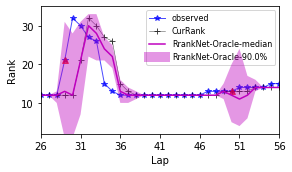

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771746.0)
ylim: (1.5499999999999998, 33.45)


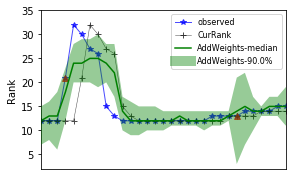

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771746.0)
ylim: (2.5999999999999996, 33.4)


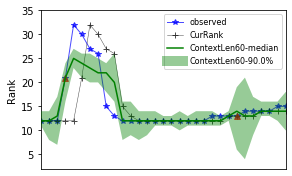

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771746.0)
ylim: (4.7, 33.3)


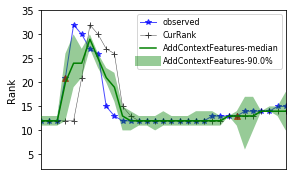

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771746.0)
ylim: (5.75, 33.25)


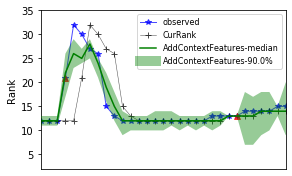

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
ylim: (7.8, 34.2)


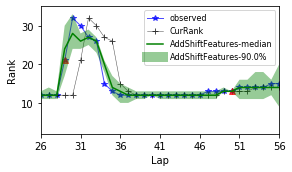

In [23]:
plot_forecast_singles(tss, target,
               rootdir + 'output',
                   colors = ['m','g','g','g','g','g'],
                   plabels= ['observed','RrankNet-Oracle','AddWeights','ContextLen60','AddContextFeatures','AddContextFeatures','AddShiftFeatures'],
                   xlim_l=25,xlim_h=55,ylim_l = 2, ylim_h=35, xscale=1.25,showfig = True)

## 2. Fig.7

In [11]:
def draw_fig7(ts_entry, forecast_entry, pits,caution, pitstop,outputfile,
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet'],
                   ylabel = 'RANK',
                 scale = 1):

    #plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    #fig, axs = plt.subplots(1, figcnt, figsize=(16,3*figcnt))
    fig, axs = plt.subplots(1, figcnt, figsize=(16*scale,3*figcnt*scale))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }       
    
    for idx in range(figcnt):
        ax = plt.subplot(figcnt, 1, idx+1)
        #ax = plt.subplot(1, figcnt, idx+1)
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        #plot_length = int(forecast_entry[idx].samples.shape[1] *1.2) 
        ts_entry[idx].iloc[:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 


        # currank
        sv = ts_entry[idx].iloc[:,0].to_numpy()
        start = pd.Timestamp("01-01-2019", freq='1min') + 2
        date_index = pd.date_range(start, periods = len(sv)-2, freq='1min')
        df2 = pd.DataFrame(sv[:-2], index=date_index)        
        df2.iloc[:,0].plot(linewidth=0.5, color='k',
                                            marker='+', alpha=0.7, zorder=-1, label='CurRank') 
        
        
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        
        
        if idx == figcnt-1:
            ax.set_xlabel('Lap')
        #if idx==0:
        ax.set_ylabel(ylabel)
        #if idx==0:
        #    plt.title(outputfile)        
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x+1) for x in offset]
        plt.xticks(new_locs, new_labels)

        if figcnt==1 or idx < figcnt -1:
            print('xlim:', plt.xlim())
            xl, xr = plt.xlim()
            xlim_h = len(ts_entry[idx])
            
            #xlim_h = 100
            ax.set_xlim((xl+0,xl+xlim_h))
        elif idx == figcnt - 1:
            xlim_h = len(ts_entry[idx])
            
            #xlim_h = 100
            ax.set_xlim((xl+0,xl+xlim_h))
        
        if ylabel=='RANK':
            ax.set_ylim((-5,+22))
        else:
            ax.set_ylim((25,175))
            
        #ax.set_xlim((80,110))
        ax.set_zorder(-1)
        #plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
        
        #add racestatus
        ax.plot(xl+pits[:,0]-1,pits[:,1],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
        
        if idx== figcnt-1:
            add_status(ax,xl, caution, pitstop)
        
        plt.text(xl + xlim_h - 25/scale, 18, plabels[idx+1],fontdict=font)
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + f'-{scale}.svg') 

In [16]:
#prepare for car 13
carno = 12
rootdir = 'DrawFigs-Data/fig7/'

alldata = []
tss, target = [], []

#mlmodels
alldata.append(loaddata('Fig3-Indy500-2018-33cars-8col-allfix.pickle'))
tsss, targets = alldata[0][carno]
tss.append(tsss[0])
target.append(targets[0])
tss.append(tsss[1])
target.append(targets[1])
tss.append(tsss[2])
target.append(targets[2])                      

#new features of oracle
modelfile = 'QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60/Indy500-2018/long_forecasting_dfs_drank_moracle.pickle'
alldata.append(loaddata(modelfile))
tsss, targets = alldata[-1][carno]
tss.append(tsss[-1])
target.append(targets[-1])

#pitmodel
modelfile = 'QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60/Indy500-2018/long_forecasting_dfs_drank_mpitmodel.pickle'
alldata.append(loaddata(modelfile))
tsss, targets = alldata[-1][carno]
tss.append(tsss[-1])
target.append(targets[-1])


modelfile = 'QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60/Indy500-2018/long_forecasting_dfs_drank_mstandard.pickle'
alldata.append(loaddata(modelfile))

(array([ 31,  49,  93, 128, 170]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


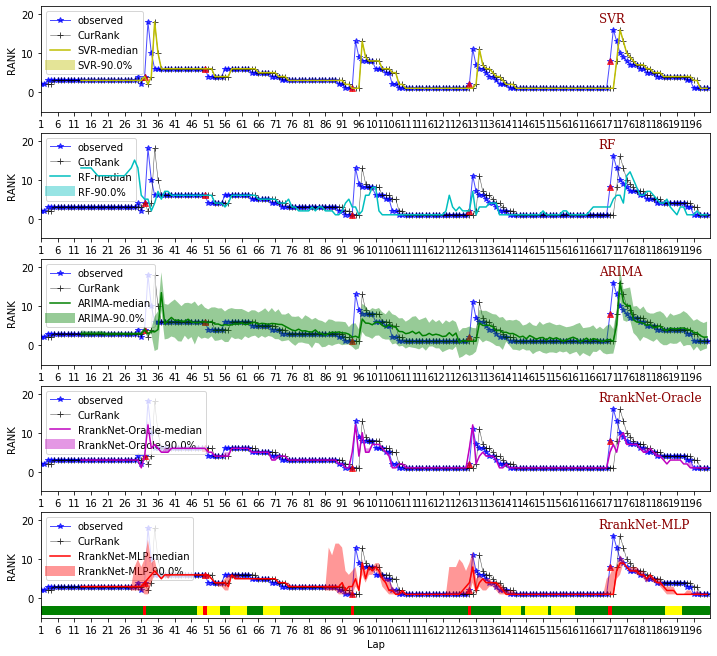

In [17]:
pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
print(np.where(pitstop==1))

outputfile = rootdir + f'car{carno}-fig7'
draw_fig7(tss, target, pits, caution, pitstop,
           outputfile,
           colors = ['y','c','g','m','r','r'],
           plabels= ['observed','SVR','RF','ARIMA','DeepAR','RankNet-Oracle','RankNet-MLP'],
         scale=0.75)
    

## 3. Fig 5

In [66]:
def plot_forecast_singles_x(ts_entry, forecast_entry, outputfile, 
                   colors = ['y','c','g','m','r'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet-Oracle','RrankNet-MLP'],
                    xlim_l=0, xlim_h=200, ylim_l=-2, ylim_h=26, xscale = 1,
                   savepdf = True, showfig = False, drawtitle = False, showgrid=True):

    prediction_intervals = [90.0]
    
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(4*xscale,3))
        ax = plt.subplot(1, 1, 1)
        
        ts_entry[idx].iloc[:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        
        if drawtitle:
            ax.set_title(plabels[idx+1])
        
        ax.set_xlabel('Lap')
        if xscale!=1 or idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x+1) for x in offset]
        plt.xticks(new_locs, new_labels)

        xlim_h = min(xlim_h, len(ts_entry[idx]))
                    
        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+xlim_l,xl+xlim_h))
        #ax.set_xlim((xl+79,xl+109))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        if ylim_h > 0:
            ax.set_ylim((ylim_l,ylim_h))
        
        ax.set_zorder(-1)
        if showgrid:
            plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
        if savepdf:
            fig.tight_layout()
            fig.savefig(outputfile + '-%d.pdf'%(idx+1))                
        if showfig:
            plt.show()
            
def drawFig5(ts_entry, forecast_entry, outputfile, 
                   colors = ['y','c','g','m','r'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet-Oracle','RrankNet-MLP'],
                    xlim_l=0, xlim_h=200, ylim_l=-2, ylim_h=26, xscale = 1,
                   savepdf = True, showfig = False, drawtitle = False,
                    drawCurRank = True, drawlegend = False):

    prediction_intervals = [90.0]
    
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
    print(np.where(pitstop==1))
    
    for idx in range(figcnt):
        #fig, axs = plt.subplots(1, 1, figsize=(4*xscale,3))
        fig, axs = plt.subplots(1, 1, figsize=(4*xscale,3))
        ax = plt.subplot(1, 1, 1)
        
        ts_entry[idx].iloc[:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
        if drawCurRank:
            # currank
            sv = ts_entry[idx].iloc[:,0].to_numpy()
            start = pd.Timestamp("01-01-2019", freq='1min') + 2
            date_index = pd.date_range(start, periods = len(sv)-2, freq='1min')
            df2 = pd.DataFrame(sv[:-2], index=date_index)        
            df2.iloc[:,0].plot(linewidth=0.5, color='k',
                                                marker='+', alpha=0.7, zorder=-1, label='CurRank') 
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        
        if drawtitle:
            ax.set_title(plabels[idx+1])
        
        if xscale!=1 or idx==0:
            ax.set_ylabel('Rank')
    
        #if idx == 0 or idx == figcnt -1:
        if True:
            ax.set_xlabel('Lap')
        
            locs, labels = plt.xticks() 
            #plt.xticks(locs, range(len(locs)))
            start_loc = locs[0]        
            offset = range(0, 200, 5)
            #new_locs = range(start_loc , start_loc+200, 10)
            new_locs = [start_loc + x for x in offset]
            #new_labels = [str(x-start_loc + 1) for x in new_locs]
            new_labels = [str(x+1) for x in offset]
            plt.xticks(new_locs, new_labels)
        else:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

        xlim_h = min(xlim_h, len(ts_entry[idx]))
                    
        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+xlim_l,xl+xlim_h))
        #ax.set_xlim((xl+79,xl+109))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        if ylim_h > 0:
            ax.set_ylim((ylim_l,ylim_h))
        
        ax.set_zorder(-1)
        #plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        if drawlegend:
            l=plt.legend(prop={'size': 8},loc='upper left')
            l.set_zorder(0.6)
        
        ax.plot(xl+pits[:,0]-1,pits[:,1],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
    
        if savepdf:
            fig.tight_layout()
            fig.savefig(outputfile + '-%d.pdf'%(idx+1))                
            #fig.savefig(outputfile + '-%s.pdf'%(plabels[idx+1]))                
        if showfig:
            plt.show()       

In [39]:
WorkRootDir = 'QuickTestOutput'
#reference
#configname = 'weighted-noinlap-nopitage-nocate-c60-drank'
#configname = 'weighted-noinlap-S0LTYP0T-nocate-c60-drank-pitmodel'
configname = 'weighted-noinlap-S0LTYP0T-nocate-c60-drank-oracle'
configfile = f'{configname}.ini'

if configfile != '':
    config = configparser.RawConfigParser()
    config.read(WorkRootDir + '/' + configfile)

    #set them back
    section = "RankNet-QuickTest"
    
    _savedata = config.getboolean(section, "_savedata")
    _skip_overwrite = config.getboolean(section, "_skip_overwrite")
    _inlap_status = config.getint(section, "_inlap_status") #0
    _feature_mode = config.getint(section, "_feature_mode") #FEATURE_STATUS
    _featureCnt = config.getint(section, "_featureCnt") #9
    freq = config.get(section, "freq") #"1min"
    _train_len = config.getint(section, "_train_len") #40
    prediction_length = config.getint(section, "prediction_length") #2
    context_ratio = config.getfloat(section, "context_ratio") #0.
    context_length =  config.getint(section, "context_length") #40
    
    dataset= config.get(section, "dataset") #'rank'
    epochs = config.getint(section, "epochs") #1000
    gpuid = config.getint(section, "gpuid") #5
    _use_weighted_model = config.getboolean(section, "_use_weighted_model")
    trainmodel = config.get(section, "trainmodel") #'deepARW-Oracle' if _use_weighted_model else 'deepAR-Oracle'
    
    _use_cate_feature = config.getboolean(section, "_use_cate_feature")
    
    distroutput = config.get(section, "distroutput") #'student'
    batch_size = config.getint(section, "batch_size") #32
    loopcnt = config.getint(section, "loopcnt") #2
    _test_event = config.get(section, "_test_event") #'Indy500-2018'
    testmodel = config.get(section, "testmodel") #'oracle'
    pitmodel = config.get(section, "pitmodel") #'oracle'
    year = config.get(section, "year") #'2018'
    
    contextlen = context_length
    use_feat_static = _use_cate_feature 
    
_forecast_mode = 'shortterm'

In [40]:
cur_featurestr = decode_feature_mode(_feature_mode)

#
# string map
#
inlapstr = {0:'noinlap',1:'inlap',2:'outlap'}
weightstr = {True:'weighted',False:'noweighted'}
catestr = {True:'cate',False:'nocate'}

#
# input data parameters
#
years = ['2013','2014','2015','2016','2017','2018','2019']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v{_featureCnt}_p{_inlap_status}'
_dataset_id = '%s-%s'%(inlapstr[_inlap_status], cur_featurestr)


#
# internal parameters
#
distr_outputs ={'student':StudentTOutput(),
                'negbin':NegativeBinomialOutput()
                }
distr_output = distr_outputs[distroutput]

#
#
#
experimentid = f'{weightstr[_use_weighted_model]}-{inlapstr[_inlap_status]}-{cur_featurestr}-{catestr[_use_cate_feature]}-c{context_length}'

#
#
#
outputRoot = f"{WorkRootDir}/{experimentid}/"

FEATURE_STATUS FEATURE_LEADER_PITCNT FEATURE_TOTAL_PITCNT FEATURE_SHIFT_TRACKSTATUS FEATURE_SHIFT_LAPSTATUS FEATURE_SHIFT_TOTAL_PITCNT


In [37]:
rootdir = 'DrawFigs-Data/fig5/'

In [41]:
with open('Fig3-Indy500-2018-33cars-l2-mlmodels.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    alldata_ml = pickle.load(f, encoding='latin1') 

testmodel = 'oracle'
#LONG_FORECASTING_DFS = f'{outputRoot}/{_test_event}/{_forecast_mode}-long_forecasting_dfs_d{dataset}_m{testmodel}.pickle'
LONG_FORECASTING_DFS = f'{outputRoot}/{_test_event}/long_forecasting_dfs_d{dataset}_m{testmodel}.pickle'
fname = LONG_FORECASTING_DFS
print('Load Long Forecasting Data:',fname)
with open(fname, 'rb') as f:
    alldata_oracle = pickle.load(f, encoding='latin1') 
    
testmodel = 'pitmodel'
#LONG_FORECASTING_DFS = f'{outputRoot}/{_test_event}/{_forecast_mode}-long_forecasting_dfs_d{dataset}_m{testmodel}.pickle'
LONG_FORECASTING_DFS = f'{outputRoot}/{_test_event}/long_forecasting_dfs_d{dataset}_m{testmodel}.pickle'
fname = LONG_FORECASTING_DFS
print('Load Long Forecasting Data:',fname)
with open(fname, 'rb') as f:
    alldata_pitmodel = pickle.load(f, encoding='latin1') 

testmodel = 'standard'
LONG_FORECASTING_DFS = f'{outputRoot}/{_test_event}/{_forecast_mode}-long_forecasting_dfs_d{dataset}_m{testmodel}.pickle'
fname = LONG_FORECASTING_DFS
print('Load Long Forecasting Data:',fname)
with open(fname, 'rb') as f:
    alldata_standard = pickle.load(f, encoding='latin1') 

Load Long Forecasting Data: QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60//Indy500-2018/long_forecasting_dfs_drank_moracle.pickle
Load Long Forecasting Data: QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60//Indy500-2018/long_forecasting_dfs_drank_mpitmodel.pickle
Load Long Forecasting Data: QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60//Indy500-2018/shortterm-long_forecasting_dfs_drank_mstandard.pickle


In [46]:
os.makedirs(rootdir, exist_ok=True)

carno = 12

tsss, targets = alldata_ml[carno]
tsss_standard, targets_standard = alldata_standard[carno]
tsss_oracle, targets_oracle = alldata_oracle[carno]
tsss_pitmodel, targets_pitmodel = alldata_pitmodel[carno]

tss_draw2 = [tsss[0],tsss[1],tsss[2],tsss_standard[0], tsss_oracle[-1],tsss_pitmodel[-1]]
target_draw2 = [targets[0],targets[1],targets[2],targets_standard[0], targets_oracle[-1], targets_pitmodel[-1]]  

(array([ 31,  49,  93, 128, 170]),)
xlim: (25771680.0, 25771879.0)
ylim: (0.1499999999999999, 18.85)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


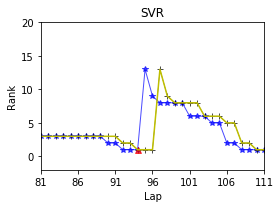

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
ylim: (0.1499999999999999, 18.85)


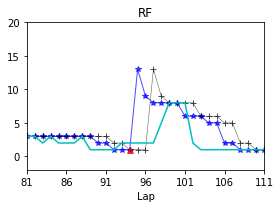

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
ylim: (-4.192672411158499, 21.950420639053636)


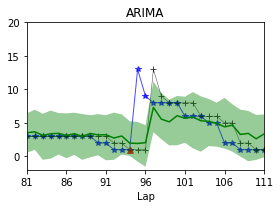

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
ylim: (0.0, 22.0)


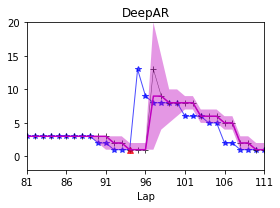

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
ylim: (0.1499999999999999, 18.85)


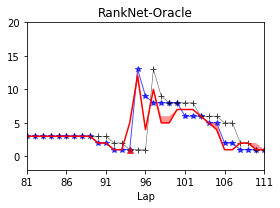

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
ylim: (0.1499999999999999, 18.85)


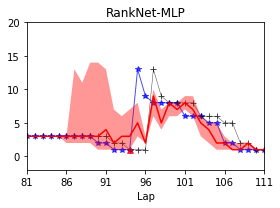

In [67]:
drawFig5(tss_draw2, target_draw2,
               f'{rootdir}/pit95-car{carno}-ranknet-rf-rank-forecast',
                   colors = ['y','c','g','m','r','r'],
                   plabels= ['observed','SVR','RF','ARIMA','DeepAR','RankNet-Oracle','RankNet-MLP'],
                   xlim_l=80, xlim_h=110,ylim_l=-2, ylim_h=20, showfig = True, drawtitle = True)

(array([ 31,  49,  93, 128, 170]),)
xlim: (25771680.0, 25771879.0)
ylim: (0.1499999999999999, 18.85)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


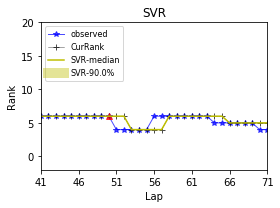

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
ylim: (0.1499999999999999, 18.85)


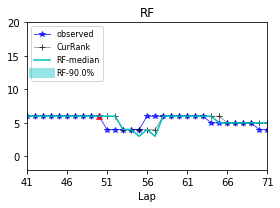

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
ylim: (-4.192672411158499, 21.950420639053636)


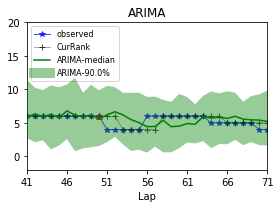

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
ylim: (0.0, 22.0)


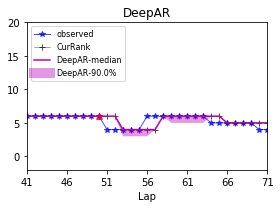

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
ylim: (0.1499999999999999, 18.85)


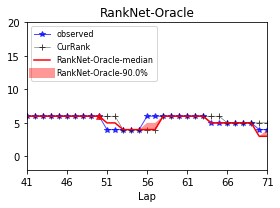

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
ylim: (0.1499999999999999, 18.85)


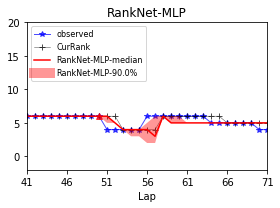

In [68]:
drawFig5(tss_draw2, target_draw2,
               f'{rootdir}/pit50-car{carno}-ranknet-rf-rank-forecast',
                   colors = ['y','c','g','m','r','r'],
                   plabels= ['observed','SVR','RF','ARIMA','DeepAR','RankNet-Oracle','RankNet-MLP'],
                   xlim_l=40,xlim_h=70,ylim_l=-2, ylim_h=20, showfig = True, drawtitle = True, drawlegend=True)